<h1>Popular Steam Game Sentiment Analysis</h1>
Dataset Citation </br>
Antoni Sobkowicz. (2017). Steam Review Dataset (2017) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1000885

License
CC BY NC 4.0|

# 1. Install & Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
# %pip install stopwords
# %pip install flair
# %pip install nltk
# %pip install swifter
# %pip install wordcloud
# %pip install pip install imbalanced-learn
# %pip install jupyter-dash

In [2]:
import pickle
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_auc_score, make_scorer, average_precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import nltk
# nltk.download()

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
pd.options.display.max_rows = None

# from scikitplot.metrics import plot_confusion_matrix

warnings.filterwarnings('ignore')


# 2. Import Steam Games Review Dataset

app_id       -> Game ID <br/>
app_name     -> Game Name <br/>
review_text  -> Review text <br/>
review_score -> Review Sentiment: whether the game the review recommends the game or not. [1: Yes, -1: No, 0: None] <br/>
review_votes -> Review vote  : whether the review was recommended by another user or not. [1: Yes, 0: No] <br/>

In [3]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


The dataset contains 6.4 Million data, I planned to scale down the dataset to < 100,000 entries.

In [5]:
# Check the amount of review from each game
dataset['app_name'].value_counts(ascending=False, dropna=True).head()

PAYDAY 2    88973
DayZ        88850
Terraria    84828
Rust        77037
Dota 2      73541
Name: app_name, dtype: int64

I familiar with Dota 2, so I decided to make sentiment analysis on the chosen game - Dota 2

In [6]:
# Create dota2 dataframe
df = dataset[dataset['app_name'] == 'Dota 2'].reset_index(drop=True)
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,570,Dota 2,"Causes anxiety problems, low self esteem, Tour...",1,1
1,570,Dota 2,This game taught me about the diversity of cul...,1,0
2,570,Dota 2,It's like roulette; fun until it turns into Ru...,1,0
3,570,Dota 2,"In Dota 2, Not many people speak your languag...",1,0
4,570,Dota 2,Side effects include: -Explosive diarrhea -Ha...,1,0


In [7]:
# Generate dota2_dataset.csv file that help to load faster in further use
df.to_csv('dota2_dataset.csv', index=False)                                                                                                                     

## Load payday2_dataset.csv dataset

In [8]:
df = pd.read_csv('dota2_dataset.csv')
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,570,Dota 2,"Causes anxiety problems, low self esteem, Tour...",1,1
1,570,Dota 2,This game taught me about the diversity of cul...,1,0
2,570,Dota 2,It's like roulette; fun until it turns into Ru...,1,0
3,570,Dota 2,"In Dota 2, Not many people speak your languag...",1,0
4,570,Dota 2,Side effects include: -Explosive diarrhea -Ha...,1,0


In [9]:
# Check the shape of the dataset
print('Dataset shape:', df.shape)

Dataset shape: (73541, 5)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73541 entries, 0 to 73540
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        73541 non-null  int64 
 1   app_name      73541 non-null  object
 2   review_text   73433 non-null  object
 3   review_score  73541 non-null  int64 
 4   review_votes  73541 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


In [11]:
df['review_text'] = df['review_text'].astype('str')

# 3. Data Cleaning For Sentiment Processing
## Basic Cleaning

In [12]:
# Remove Null values
df2 = df.dropna(inplace=False)

# Remove Duplicate Values
df2 = df.drop_duplicates(keep='first')


In [13]:
df2.shape


(50190, 5)

After basic cleaning, there are 50190 entries left with 5 coloumns.




## Enhanced Cleaning

In [14]:
# Define required cleaning function
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')

# Remove hyperlinks and markup
def removeHyperlink(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

# Remove Numeric
def remove_num(text):
    output = re.sub(r'\d+', '', text)
    return output

# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', text)

# Remove Symbol
def remove_symbols(text):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return cleaned_string

# Remove Punctuation
def remove_punctuation(text):
    final = "".join(u for u in text if u not in (
        "?", ".", ";", ":",  "!", '"', ','))
    return final

# Remove Stopwords
def remove_stopword(text):
    stop = set(stopwords.words("english"))
    stemmer = PorterStemmer()
    lemma = WordNetLemmatizer()

    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

# Unify Whitespaces
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text)
    return cleaned_string

# Normalize words using Stemming
def Stemming(text):
    stem = []
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    stem = ' '.join(stemmed_word)
    return stem


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def cleaning(df, review):
    df[review] = df[review].apply(removeHyperlink)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

cleaning(df2, 'review_text')
df2[['review_text']].head(10)


,review_text
0,caus anxieti problem low self esteem tourett s...
1,game taught divers cultur small littl corner u...
2,like roulett fun turn russian
3,dota mani peopl speak languag mani peopl play ...
4,side effect includ explos diarrhea hatr human ...
5,hour fun select russia want play today
6,game murder tree kill ancient creatur chill ca...
7,dota start game ruin social life spend everi d...
8,play game thought brazillian bad soccer
9,game made racist toward speak languag english ...


After enhanced cleaning, data is prepared to be use for model training. 

# 4. EDA (Analysis and Visualization)

## Distribution of Reviews in Each Sentiment

In [16]:
sentiment_counts = df2.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text', ascending=False)

sentiment_counts


,review_score,review_text
1,1,42369
0,-1,7821


<AxesSubplot:xlabel='review_score', ylabel='count'>

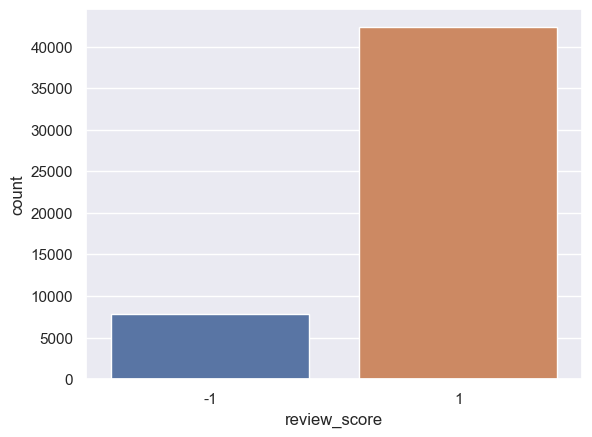

In [17]:
# Visualization the sentiment_counts.
sns.set_theme(style='darkgrid')
sns.countplot(x='review_score', data=df2)


### Conclude: Positive > Negative
We can see that there are more positive sentiment reviews than negative sentiment reviews.

## WordCloud of Our Review Text

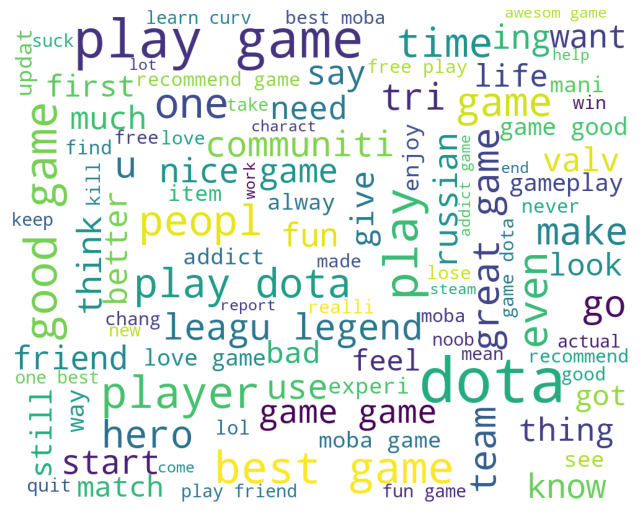

In [18]:
txt = ' '.join(df2['review_text'].values.tolist())

wordcloud = WordCloud(
    background_color='white',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=800
).generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


### WordCloud of Each Sentiment Review Text

In [19]:
positive = df2[df2['review_score'] == 1]
negative = df2[df2['review_score'] == -1]


#### Positive Sentiment Reviews

<Figure size 1500x800 with 0 Axes>

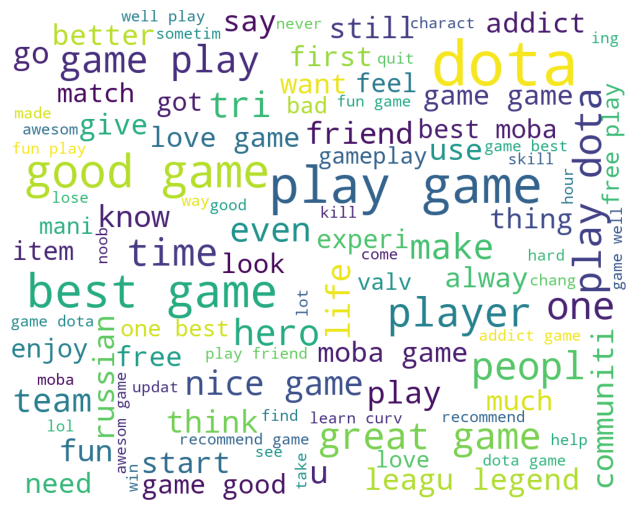

In [20]:
# Positive Sentiment Reviews
txt = ' '.join(positive['review_text'].values.tolist())
plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='white',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=800
).generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


We can see that for postive sentiment review, the most common words are 'good', 'great', 'best', etc as shown in wordcloud above.

#### Negative Sentiment Reviews

<Figure size 1500x800 with 0 Axes>

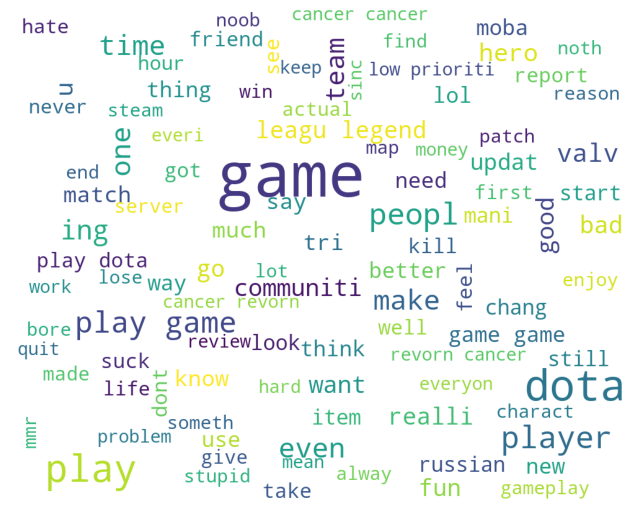

In [21]:
txt = ' '.join(negative['review_text'].values.tolist())
plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='white',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=800
).generate(txt)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


And we can see that for negative sentiment review, the most common words are 'bad' etc as shown in wordcloud above. 

## Distribution of Number of Review Words

<AxesSubplot:xlabel='Num_word_review', ylabel='Count'>

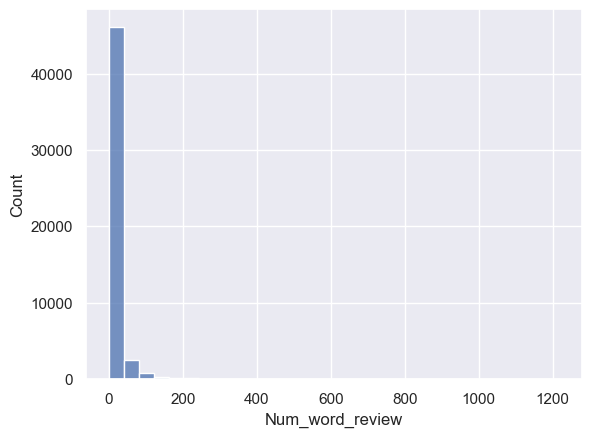

In [22]:
df_Num_word_review = df2.copy()
df_Num_word_review['Num_word_review'] = df2['review_text'].apply(
    lambda x: len(str(x).split()))

sns.histplot(data=df_Num_word_review, x="Num_word_review", bins=30)


### Observation on Result
As we can see that most of our review texts contain 1-100 words.

## Distribution of Words in All Review Texts

In [23]:
df2['temp_list'] = df2['review_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in df2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='autumn')


,Common_words,count
0,game,54203
1,play,24024
2,dota,16408
3,like,8404
4,good,7974
5,get,7399
6,best,6550
7,time,6058
8,fun,5477
9,player,5233


Obeservation: game & play is the highest distribution of words.

# 5. Creating Bag of Words and Text Classifier Model
## Creating pipeline for tokenizing and modelling

In [24]:
# Split the dataset into input (X) and target (y)
X = df2['review_text'].values
y = df2['review_score'].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=25, test_size=0.2)

# Data Transformation using CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english", max_features=3000)
X_train_transformed = count_vectorizer.fit_transform(X_train)
X_test_transformed = count_vectorizer.transform(X_test)

In [25]:
# Define a function to calculate performance metrics
def calculate_metrics(y_test, y_pred):
    print('Classification Report:\n', classification_report(
        y_test, y_pred, labels=[1, -1]))

    # Plot Confusion Matrix
    try:
        print('Confusion Matrix:')
        # create a figure object with a specific size
        fig, ax = plt.subplots(figsize=(3, 2))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=[
                    'Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax)

        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        plt.show()
    except:
        print('Unable to plot confusion matrix!')

    cfmat = confusion_matrix(y_test, y_pred)
    print('TN - True Negative {}'.format(cfmat[0, 0]))
    print('FP - False Positive {}'.format(cfmat[0, 1]))
    print('FN - False Negative {}'.format(cfmat[1, 0]))
    print('TP - True Positive {}'.format(cfmat[1, 1]))

    print('Accuracy Rate: {:.4f}'.format(
        np.divide(np.sum([cfmat[0, 0], cfmat[1, 1]]), np.sum(cfmat))))
    print(
        'F1-Score     : {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
    print(
        'PR AUC      : {:.4f}'.format(average_precision_score(y_test, y_pred)))


Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.98      0.92      8445
          -1       0.67      0.24      0.35      1593

    accuracy                           0.86     10038
   macro avg       0.77      0.61      0.64     10038
weighted avg       0.84      0.86      0.83     10038

Confusion Matrix:


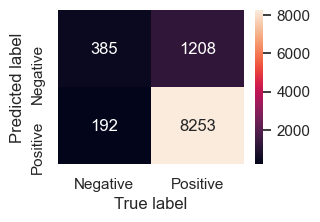

TN - True Negative 385
FP - False Positive 1208
FN - False Negative 192
TP - True Positive 8253
Accuracy Rate: 0.8605
F1-Score     : 0.8318
PR AUC      : 0.8716


In [26]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=25, n_jobs=2)),
])

# Fit the pipeline on the training data
base_model = pipeline.fit(X_train_transformed, y_train)

# Make predictions on the testing data
predictions = base_model.predict(X_test_transformed)

# Calculate performance metrics on the testing data
calculate_metrics(y_test, predictions)

In [27]:
# Resample Data
over_sampler = SMOTE(sampling_strategy='minority')
under_sampler = RandomUnderSampler(sampling_strategy='majority')
pipeline_imbalance = ImbPipeline(
    steps=[('over', over_sampler), ('under', under_sampler)])
try:
    X_train_resampled, y_train_resampled = pipeline_imbalance.fit_resample(
        X_train_transformed, y_train)
except ValueError as e:
    print(f"Error during resampling: {e}")
    raise SystemExit

# Print the class proportion after oversampling and undersampling
print("Tweet Sentiment Class Proportion after oversampling and undersampling: \n",
      Counter(y_train_resampled))


Tweet Sentiment Class Proportion after oversampling and undersampling: 
 Counter({-1: 33924, 1: 33924})


In [28]:
# Define the pipelines
pipeline_rf = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=25, n_jobs=-1)),
])

pipeline_svc = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(random_state=25, probability=True)),
])

pipeline_mnb = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Define hyperparameters to tune with GridSearchCV
rf_param_grid = [{
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['auto', 'sqrt', 'log2']}]

svm_param_grid = [{
    'clf__C': [0.1, 1, 10]}]

mnb_param_grid = [{
    'clf__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}]

# Define cross-validation with KFold
cv = KFold(n_splits=5, shuffle=True, random_state=25)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score)
}

# Setup GridSearchCV for all models
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=rf_param_grid,
                              scoring=scoring,
                              cv=cv,
                              verbose=1, n_jobs=-1, refit='roc_auc')

grid_search_svc = GridSearchCV(estimator=pipeline_svc,
                               param_grid=svm_param_grid,
                               scoring=scoring,
                               cv=cv,
                               verbose=1, n_jobs=-1, refit='roc_auc')

grid_search_mnb = GridSearchCV(estimator=pipeline_mnb,
                               param_grid=mnb_param_grid,
                               scoring=scoring,
                               cv=cv,
                               verbose=1, n_jobs=-1, refit='roc_auc')


In [29]:
grid_models = [grid_search_rf, grid_search_svc, grid_search_mnb]

for model in grid_models:
    model.fit(X_train_resampled, y_train_resampled)
    
    best_index = model.best_index_
    mean_test_accuracy = model.cv_results_['mean_test_accuracy']
    mean_test_f1 = model.cv_results_['mean_test_f1']
    mean_test_roc_auc = model.cv_results_['mean_test_roc_auc']
    
    print(
        f"Best parameters for {type(model.estimator['clf']).__name__}: \n{model.best_params_}")
    print(
        f"Best Accuracy (val) for {type(model.estimator['clf']).__name__}: {mean_test_accuracy[best_index]}")
    print(
        f"Best ROC_AUC  (val) for {type(model.estimator['clf']).__name__}: {mean_test_roc_auc[best_index]}")
    print(
        f"Best F1 Score (val) for {type(model.estimator['clf']).__name__}: {mean_test_f1[best_index]} \n")
    

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for RandomForestClassifier: 
{'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best Accuracy (val) for RandomForestClassifier: 0.8741893115093451
Best ROC_AUC  (val) for RandomForestClassifier: 0.8741901515746997
Best F1 Score (val) for RandomForestClassifier: 0.8741863461013019 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for SVC: 
{'clf__C': 10}
Best Accuracy (val) for SVC: 0.8851255774886327
Best ROC_AUC  (val) for SVC: 0.8851262420550517
Best F1 Score (val) for SVC: 0.8850780778843401 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for MultinomialNB: 
{'clf__alpha': 0.7}
Best Accuracy (val) for MultinomialNB: 0.8176220809353845
Best ROC_AUC  (val) for MultinomialNB: 0.8178385084565623
Best F1 Score (val) for MultinomialNB: 0.8174744096939092 



Model: RandomForestClassifier
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.93      0.96     33924
          -1       0.71      0.99      0.83      6228

    accuracy                           0.94     40152
   macro avg       0.85      0.96      0.89     40152
weighted avg       0.95      0.94      0.94     40152

Confusion Matrix:


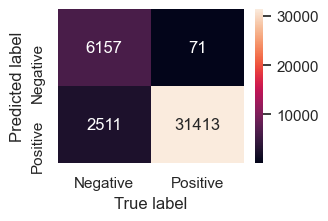

TN - True Negative 6157
FP - False Positive 71
FN - False Negative 2511
TP - True Positive 31413
Accuracy Rate: 0.9357
F1-Score     : 0.9398
PR AUC      : 0.9864


Model: SVC
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.92      0.96     33924
          -1       0.70      0.98      0.82      6228

    accuracy                           0.93     40152
   macro avg       0.85      0.95      0.89     40152
weighted avg       0.95      0.93      0.94     40152

Confusion Matrix:


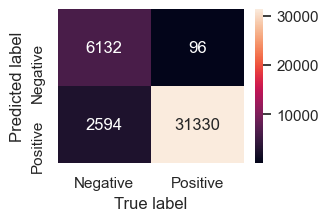

TN - True Negative 6132
FP - False Positive 96
FN - False Negative 2594
TP - True Positive 31330
Accuracy Rate: 0.9330
F1-Score     : 0.9373
PR AUC      : 0.9853


Model: MultinomialNB
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.82      0.87     33924
          -1       0.38      0.61      0.47      6228

    accuracy                           0.79     40152
   macro avg       0.65      0.72      0.67     40152
weighted avg       0.84      0.79      0.80     40152

Confusion Matrix:


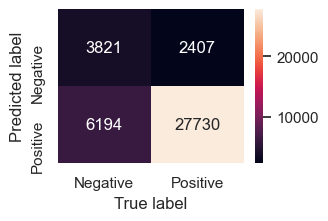

TN - True Negative 3821
FP - False Positive 2407
FN - False Negative 6194
TP - True Positive 27730
Accuracy Rate: 0.7858
F1-Score     : 0.8044
PR AUC      : 0.9064




In [30]:
for model in grid_models:
    # Make predictions on the training data
    predictions = model.best_estimator_.predict(X_train_transformed)
    print(f"Model: {type(model.estimator['clf']).__name__}")

    # Calculate performance metrics on the training data
    calculate_metrics(y_train, predictions)
    print("\n")

Model: RandomForestClassifier
Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.88      0.89      8445
          -1       0.40      0.42      0.41      1593

    accuracy                           0.81     10038
   macro avg       0.65      0.65      0.65     10038
weighted avg       0.81      0.81      0.81     10038

Confusion Matrix:


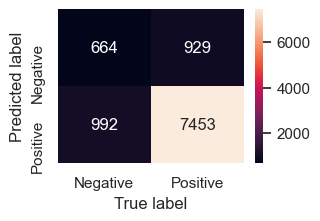

TN - True Negative 664
FP - False Positive 929
FN - False Negative 992
TP - True Positive 7453
Accuracy Rate: 0.8086
F1-Score     : 0.8101
PR AUC      : 0.8835


Model: SVC
Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.87      0.89      8445
          -1       0.44      0.55      0.49      1593

    accuracy                           0.82     10038
   macro avg       0.68      0.71      0.69     10038
weighted avg       0.84      0.82      0.83     10038

Confusion Matrix:


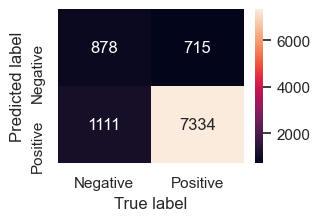

TN - True Negative 878
FP - False Positive 715
FN - False Negative 1111
TP - True Positive 7334
Accuracy Rate: 0.8181
F1-Score     : 0.8260
PR AUC      : 0.9020


Model: MultinomialNB
Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.81      0.86      8445
          -1       0.36      0.58      0.45      1593

    accuracy                           0.77     10038
   macro avg       0.64      0.70      0.65     10038
weighted avg       0.82      0.77      0.79     10038

Confusion Matrix:


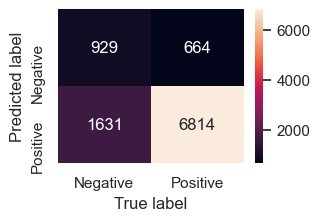

TN - True Negative 929
FP - False Positive 664
FN - False Negative 1631
TP - True Positive 6814
Accuracy Rate: 0.7714
F1-Score     : 0.7910
PR AUC      : 0.8977




In [31]:
for model in grid_models:
    # Make predictions on the testing data
    predictions = model.best_estimator_.predict(X_test_transformed)
    print(f"Model: {type(model.estimator['clf']).__name__}")
    
    # Calculate performance metrics on the testing data
    calculate_metrics(y_test, predictions)
    print("\n")

In [32]:
# Serialize the model to a file
with open('model/rf.pkl', 'wb') as f:
    pickle.dump(grid_models[0], f)
    
# Serialize the model to a file
with open('model/svc.pkl', 'wb') as f:
    pickle.dump(grid_models[1], f)
    
# Serialize the model to a file
with open('model/mnb.pkl', 'wb') as f:
    pickle.dump(grid_models[2], f)
    
# Serialize the CountVectorizer to a file
with open('model/transformer.pkl', 'wb') as f:
    pickle.dump(count_vectorizer, f)

In [33]:
import pickle
# Load the saved model using pickle
with open('model/mnb.pkl', 'rb') as f:
    mnb_model = pickle.load(f)

with open('model/svc.pkl', 'rb') as f:
    svc_model = pickle.load(f)

# Load the trained model using pickle
with open('model/rf.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [35]:
from sklearn.ensemble import VotingClassifier
# Define the ensemble classifier using a VotingClassifier
ensemble = VotingClassifier(
    estimators=[('svm', svc_model), ('rfc', rf_model)], voting='soft')

# Enable GPU acceleration with scikit-learn using the 'n_jobs' parameter
ensemble.n_jobs = -1

ensemble.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('svm',
                              GridSearchCV(cv=KFold(n_splits=5, random_state=25, shuffle=True),
                                           estimator=Pipeline(steps=[('tfidf',
                                                                      TfidfTransformer()),
                                                                     ('clf',
                                                                      SVC(probability=True,
                                                                          random_state=25))]),
                                           n_jobs=-1,
                                           param_grid=[{'clf__C': [0.1, 1,
                                                                   10]}],
                                           refit='roc_auc',
                                           scoring={'accuracy': make_scorer(accuracy_score),
                                                    'f1': make_scorer(f1_score, average=weigh...
                                                                                             random_state=25))]),
                                           n_jobs=-1,
                                           param_grid=[{'clf__max_depth': [None,
                                                                           5,
                                                                           10],
                                                        'clf__max_features': ['auto',
                                                                              'sqrt',
                                                                              'log2'],
                                                        'clf__min_samples_split': [2,
                                                                                   5],
                                                        'clf__n_estimators': [50,
                                                                              100,
                                                                              200]}],
                                           refit='roc_auc',
                                           scoring={'accuracy': make_scorer(accuracy_score),
                                                    'f1': make_scorer(f1_score, average=weighted),
                                                    'roc_auc': make_scorer(roc_auc_score)},
                                           verbose=1))],
                 n_jobs=-1, voting='soft')

In [36]:
# Serialize the model to a file
with open('model/ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

In [37]:
# Load the trained model using pickle
with open('model/ensemble.pkl', 'rb') as f:
    ensemble_model = pickle.load(f)

In [38]:
ensemble_model


VotingClassifier(estimators=[('svm',
                              GridSearchCV(cv=KFold(n_splits=5, random_state=25, shuffle=True),
                                           estimator=Pipeline(steps=[('tfidf',
                                                                      TfidfTransformer()),
                                                                     ('clf',
                                                                      SVC(probability=True,
                                                                          random_state=25))]),
                                           n_jobs=-1,
                                           param_grid=[{'clf__C': [0.1, 1,
                                                                   10]}],
                                           refit='roc_auc',
                                           scoring={'accuracy': make_scorer(accuracy_score),
                                                    'f1': make_scorer(f1_score, average=weigh...
                                                                                             random_state=25))]),
                                           n_jobs=-1,
                                           param_grid=[{'clf__max_depth': [None,
                                                                           5,
                                                                           10],
                                                        'clf__max_features': ['auto',
                                                                              'sqrt',
                                                                              'log2'],
                                                        'clf__min_samples_split': [2,
                                                                                   5],
                                                        'clf__n_estimators': [50,
                                                                              100,
                                                                              200]}],
                                           refit='roc_auc',
                                           scoring={'accuracy': make_scorer(accuracy_score),
                                                    'f1': make_scorer(f1_score, average=weighted),
                                                    'roc_auc': make_scorer(roc_auc_score)},
                                           verbose=1))],
                 n_jobs=-1, voting='soft')

Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.89      0.89      8445
          -1       0.43      0.46      0.44      1593

    accuracy                           0.82     10038
   macro avg       0.66      0.67      0.67     10038
weighted avg       0.82      0.82      0.82     10038

Confusion Matrix:


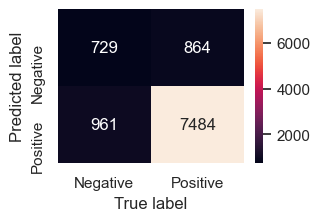

TN - True Negative 729
FP - False Positive 864
FN - False Negative 961
TP - True Positive 7484
Accuracy Rate: 0.8182
F1-Score     : 0.8204
PR AUC      : 0.8902


In [39]:
# Make predictions on the testing data
y_pred = ensemble_model.predict_proba(X_test_transformed)[:, 1]

y_pred_binary = (y_pred >= 0.5).astype(np.int64)
y_pred_binary[y_pred_binary == 0] = -1

calculate_metrics(y_test, y_pred_binary)
